## BMW MDR - Geo clustering

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install kqlmagic -U


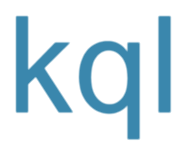

<IPython.core.display.Javascript object>

In [4]:
reload_ext Kqlmagic

#### Define helper function to execute KQL query, convert it to pandas DataFrame & cache it locally

In [5]:
# 1. Specify KQL query
# 2. Implement simple result cache in local binary (pickle) file, based on hash of the KQL query string
#
# NOTE: to make hash() consistent set env. variable PYTHONHASHSEED=0
#
%env PYTHONHASHSEED=0

def adx_query(q):
    fn = "df" + str(hash(q)) + ".pkl"
    try:
        df = pd.read_pickle(fn)
        print("Load df from " + fn)
        return df
    except:
        print("Execute query...")
        %kql res << -query q
        try:
            df = res.to_dataframe()
            print("Save df to " + fn)
            df.to_pickle(fn)
            print("\n", df.shape, "\n", df.columns)
            return df
        except Exception as ex:
            print(ex)
            return None

env: PYTHONHASHSEED=0


### Connect to MDR cluster & DB

In [6]:
%kql kusto://code;cluster='https://mdrnext.westeurope.kusto.windows.net';database='mdr'

<IPython.core.display.Javascript object>

In [11]:
q = '''
let min_pct=5;
let max_pct=95;
StdBusDataParsed
| summarize n=count(), stime=percentile(occurTime, min_pct), etime=percentile(occurTime, max_pct), num_cars=dcount(serno),
west=percentile(mdrLong, min_pct), east=percentile(mdrLong, max_pct), south=percentile(mdrLat, min_pct), north=percentile(mdrLat, max_pct),
west1=percentile(longitude, min_pct), east1=percentile(longitude, max_pct), south1=percentile(latitude, min_pct), north1=percentile(latitude, max_pct)
'''

In [12]:
df = adx_query(q)
df[:4]

Execute query...
Save df to df-775383299515302378.pkl

 (1, 12) 
 Index(['n', 'stime', 'etime', 'num_cars', 'west', 'east', 'south', 'north',
       'west1', 'east1', 'south1', 'north1'],
      dtype='object')


,n,stime,etime,num_cars,west,east,south,north,west1,east1,south1,north1
0,18235361,2019-04-05 04:16:37.413461200,2019-06-19 08:54:17.975847400,463,9.093597,12.342607,47.649364,49.928998,-0.001576,12.21122,0.000459,49.813007


### Retrieve aggregated locations and plot heatmap

In [13]:
# Define area & time limits

south = df.south[0]
north = df.north[0]
west = df.west[0]
east = df.east[0]
stime = df.stime[0]
etime = df.etime[0]

In [15]:
prefix_q = '''
set notruncation;
let South=south; let North=north; let West=west; let East=east; let Stime=stime; let Etime=etime;// copy Python variables to ADX
StdBusDataParsed
| where occurTime between(Stime..Etime)
| where mdrLat between(South..North) and mdrLong between(West..East)
'''

In [16]:
q = prefix_q + \
'''
| extend Lat=round(mdrLat, 4), Long=round(mdrLong, 4)
| summarize num=count() by Lat, Long
'''

aggr_locs = adx_query(q)

Load df from df-3282576642087785687.pkl


In [18]:
print(aggr_locs[-4:])

             Lat     Long  num
1448798  48.0764  11.6612    1
1448799  48.0763  11.6617    1
1448800  48.0763  11.6618    1
1448801  48.0762  11.6619    1


In [19]:
# Initialize graphics for heatmap

new_style = {'grid':False}
matplotlib.rc('axes', **new_style)
from matplotlib import rcParams
rcParams['figure.figsize'] = [15, 15]

## Plot heatmap of locations

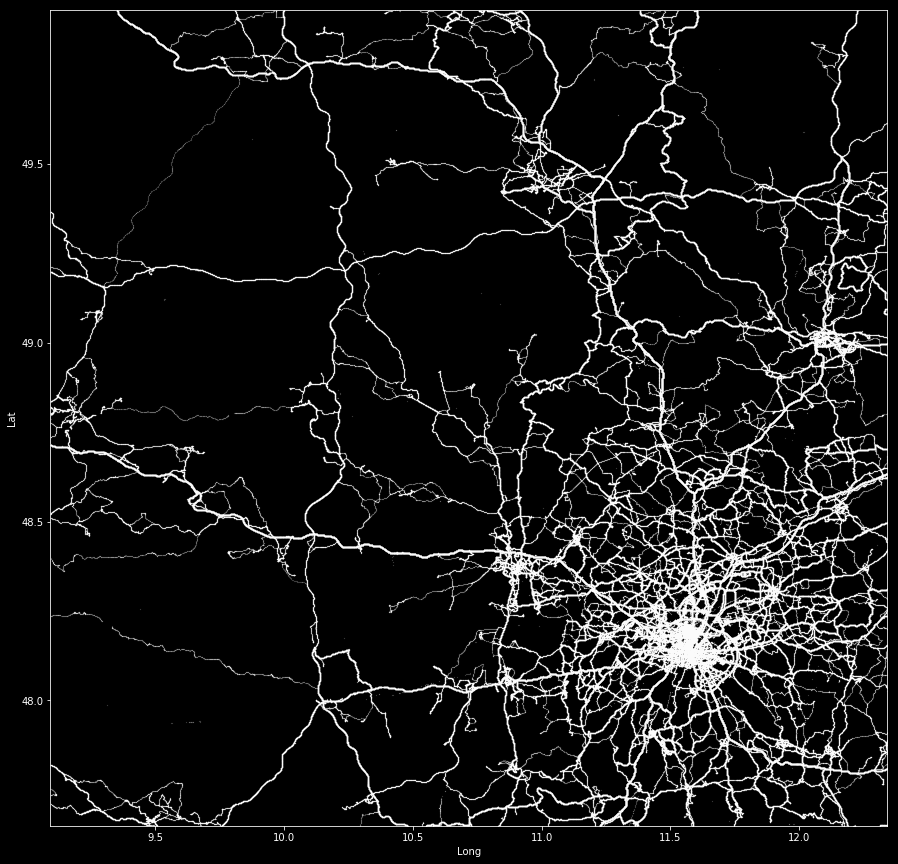

In [20]:
plt.style.use('dark_background')
p = aggr_locs.plot(kind='scatter', x='Long', y='Lat', color='white', xlim=(west, east), ylim=(south, north), s=0.02, alpha=0.6)

## Overlay on map

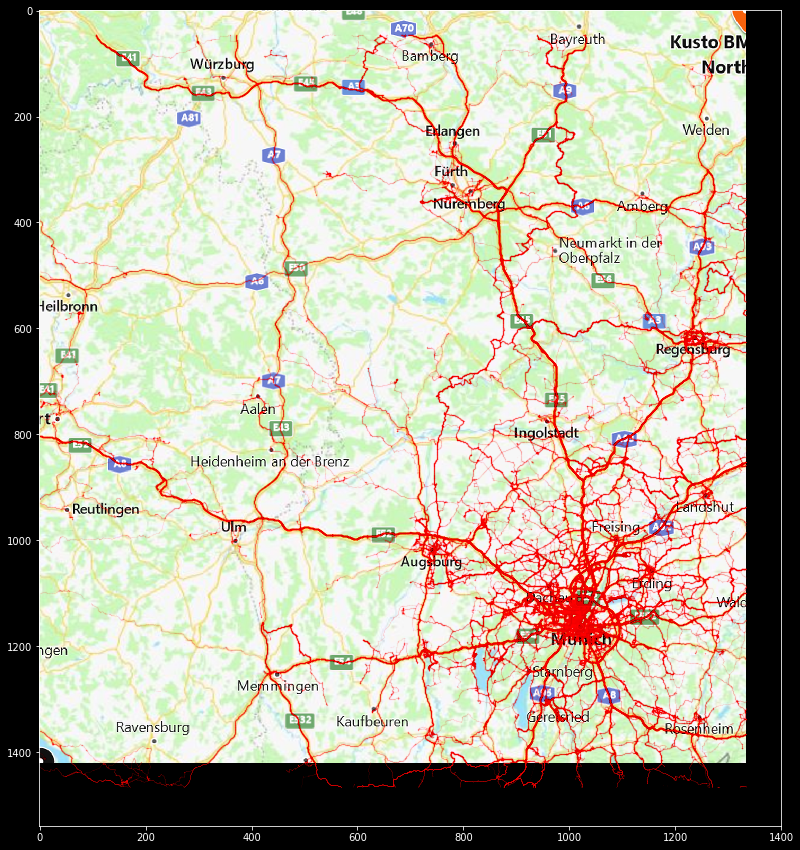

In [14]:
im = plt.imread('BingMap.PNG')
height = im.shape[0]
width = im.shape[1]
x_coord = (aggr_locs.Long - west) / (east - west) * width
y_coord = (aggr_locs.Lat - north) / (south - north) * height + 45

implot = plt.imshow(im)
plt.scatter(x=x_coord, y=y_coord, c='r', s=0.02, alpha=0.1)
plt.show()

## Clustering using K-Means

#### Let's look at the raw data on ADX

In [21]:
adx_query(prefix_q + '| take 3')

Load df from df5611269066853437034.pkl


,serno,occurTime,systemInputTime,longitude,latitude,mdrLong,mdrLat,torque,rpm,gpsSpeed,speed,range,sLoad,pLoad,state,fuel,mdrTemperature,aussenTemp,kmStand
0,4356112,2019-06-18 18:24:30.230,2019-06-18 18:24:33,11.767115,48.385408,11.767137,48.385364,-27,0,47,48,125,24,16,,0,26.8,24.0,3634
1,4356112,2019-06-18 18:24:35.239,2019-06-18 18:24:38,11.767200,48.385883,11.767233,48.385876,3,0,39,40,125,16,16,,0,26.8,24.0,3634
2,4356112,2019-06-18 18:24:40.251,2019-06-18 18:24:44,11.766877,48.386361,11.766928,48.386341,11,0,40,42,125,16,16,,0,26.8,24.0,3634


In [22]:
adx_query(prefix_q + '| count')

Load df from df-2051891104690719055.pkl


,Count
0,9175284


#### Retrieve a small portion (1%) of the raw data from ADX for testing & tuning the model (avoiding network traffic and high memory consumption)

In [23]:
q = prefix_q + \
'''
| where rand() < 0.01 // Extract 1% of the raw data
| project serno, occurTime, mdrLong, mdrLat, torque, rpm, speed
'''

df = adx_query(q)

Load df from df-2557332743687014056.pkl


#### Define helper function for K-Means

In [24]:
def KMeans_clustering(k, features):
    from sklearn.cluster import KMeans, MiniBatchKMeans
    km = MiniBatchKMeans(n_clusters=k) if features.shape[0] > 1000 else KMeans(n_clusters=k)
    km.fit(features, sample_weight=None)
    centroids = pd.DataFrame(km.cluster_centers_, columns=features.columns)
    centroids.insert(features.shape[1], "num", pd.DataFrame(km.labels_, columns=["n"]).groupby("n").size())
    centroids.insert(features.shape[1], "cluster_id", range(k))
    return centroids, km.labels_, km

#### Cluster torque, rpm & speed (on 1% of the data)

In [25]:
centroids, clusters, kmeans = KMeans_clustering(3, df[['torque', 'rpm', 'speed']])
centroids

,torque,rpm,speed,cluster_id,num
0,191.860140,3157.167832,126.895105,0,7485
1,-8.758838,41.280303,5.226010,1,42804
2,52.972932,1362.523308,54.048120,2,41467


In [26]:
q = prefix_q + \
'''
| extend Lat=round(mdrLat, 4), Long=round(mdrLong, 4)
| summarize num=count(), torque=avg(torque), rpm=avg(rpm), speed=avg(speed) by Lat, Long
'''

aggr_locs = adx_query(q)

Load df from df8833706317928931302.pkl


In [27]:
loc_clusters = kmeans.predict(aggr_locs[['torque', 'rpm', 'speed']])

In [28]:
colors = np.array(['b','r','g'])

#### Plotting over the heat map

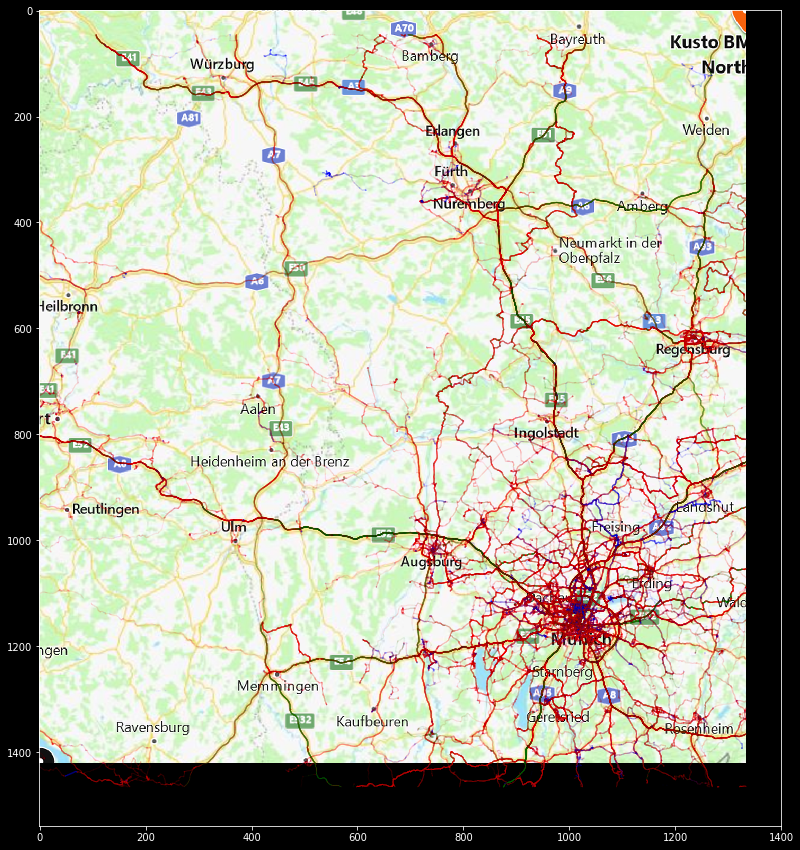

In [24]:
im = plt.imread('BingMap.PNG')
height = im.shape[0]
width = im.shape[1]
x_coord = (aggr_locs.Long - west) / (east - west) * width
y_coord = (aggr_locs.Lat - north) / (south - north) * height + 45

implot = plt.imshow(im)
plt.scatter(x=x_coord, y=y_coord, c=colors[loc_clusters], s=0.02, alpha=0.1)
plt.show()